In [1]:
import sys
if not './' in sys.path:
    sys.path.append('./')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import numpy as np
from datetime import datetime

from envs.stocks_env import Stocks_env
from datasets import nyse
import io

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Load Data</h2>

In [3]:
#data = nyse.load_data('../data/')
data, tokenized_industry, vocabulary_size = nyse.load_data_with_industry('../data/')

<h2>Training Parameters</h2>

In [4]:
batch_size = 3
window_size = 32
run_lenght = 32
alpha = 256

# Hyper params:
run_lenght       = 32
batch_size       = 256
num_epochs       = 256

# log
save_directory = 'results/saved-timesteps/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "stonks-random-" + date
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)
mean_reward = tf.keras.metrics.Mean(name='mean_reward')

<h2>Create Enviroment</h2>

In [5]:
# initialize env
env = Stocks_env(data, batch_size, window_size, run_lenght, clip=True, alpha=alpha, 
                 tokenized_industry=tokenized_industry)

<h2>Create Model</h2>

In [6]:
# initialize the model
model = tfp.distributions.Uniform(low=np.full((batch_size), -1.5), high=1.5)

<h2>Train</h2>

In [7]:
def plot(epochs, rewards):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.suptitle('frame %s. ' % epochs[-1])
    plt.title('reward: %s' % rewards[-1])
    plt.plot(epochs, rewards)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    plt.show()
    return image

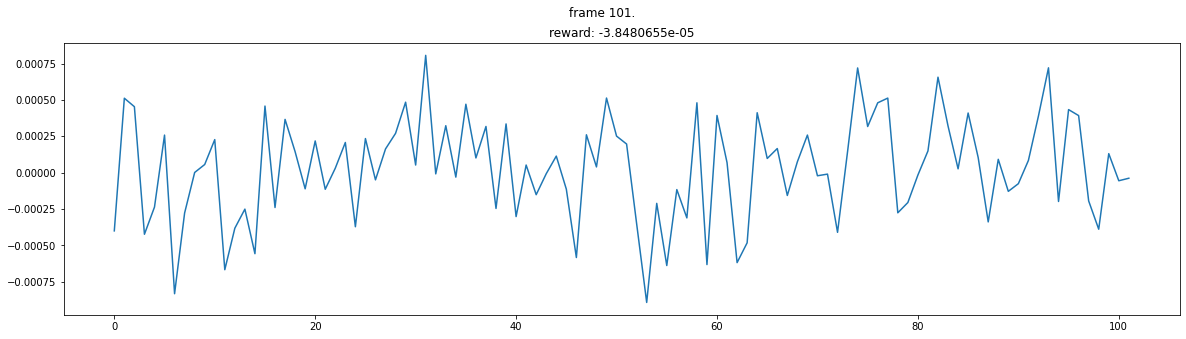

KeyboardInterrupt: 

In [8]:
rewards = []
epoch  = 0
epochs = []

while epoch < num_epochs:

    env.reset(trader_happiness=0, training=True, batch_size=batch_size)

    done = False
    while not done:
        dist = model

        action = dist.sample()
        _, reward, done, _, _ = env.step(action)
        mean_reward(reward/alpha)

    rewards.append(mean_reward.result().numpy())
    epochs.append(epoch)
    with test_summary_writer.as_default():
        tf.summary.scalar('mean_reward', mean_reward.result(), step=epoch)
        tf.summary.image('Plot', plot(epochs, rewards), step=epoch)
    mean_reward.reset_states()
    epoch += 1